# Microproyecto 4

EQUIPO 6

Juan Pablo Gutiérrez Tamayo jugutierrezt@unal.edu.co <br>
Deumek Hernandez Zuleta dehernandezz@unal.edu.co


Este microproyecto clasifica 50 especies de mariposas mediante una red neuronal convolucional de clasificación.


## Imports

Se debe importar el archivo kaggle.json el cual es el token de activación para poder consumir el servicio de la API de Kaggle.

In [ ]:
#Importe de librerías
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
import math
import os
import cv2
from sklearn.metrics import confusion_matrix
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from random import randint, choice, choices
from tensorflow import keras
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score

# Constantes.
WORKSPACE_FOLDER_PATH = "/content/drive/MyDrive/IA 2022-2/MP4"
LABELS_DATASET_FILENAME = "Labels.csv"
DATASET_FOLDER_NAME = "Dataset"
OUTPUT_FOLDER_NAME = "Outputs"

RESNET50_INPUT_SHAPE = (224, 224, 3)
TEST_SET_FRACTION = 0.2  # Fracción de todo el conjunto de datos.
STOPPING_PATIENCE = 8  # Epochs
LR_PATIENCE = 4  # Epochs
MODEL_V1_NAME = "model_v1"
INITIAL_LR = 0.0001
BATCH_SIZE = 32
MAX_EPOCHS = 25
VALIDATION_SET_FRACTION = 0.2  # Fracción del conjunto de entrenamiento.

In [ ]:
#Intalación kaggle
!pip install  -q kaggle

In [ ]:
#Importe token activación de kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"juanpablogt","key":"c8e374026229acf7f12ccdd6a866bf8f"}'}

In [ ]:
#Creación del directorio kaggle
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#Copia del token de activación
! cp kaggle.json ~/.kaggle/

In [ ]:
#Listado de datasets de kaggle
! kaggle datasets list

ref                                                             title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                             9KB  2022-10-06 08:55:25          14574        435  1.0              
swaptr/layoffs-2022                                             Layoffs 2022                                29KB  2022-11-16 20:46:46            953         34  1.0              
akshaydattatraykhare/data-for-admission-in-the-university       Data for Admission in the University         4KB  2022-10-27 11:05:45           3360         75  1.0              
aneesayoub/world-universities-ranking-2022                      World Universities Ranking 2022          

In [ ]:
#Importe del dataset mariposas
! kaggle datasets download -d gpiosenka/butterfly-images40-species

butterfly-images40-species.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Descompresión
!unzip butterfly-images40-species.zip

Archive:  butterfly-images40-species.zip
replace BUTTERFLIES-97.77.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 


## Función carga de imágenes

In [ ]:
#Diccionario de clases
clases = {
  'ADONIS':0,
  'AFRICAN GIANT SWALLOWTAIL':1,
  'AMERICAN SNOOT':2,
  'AN 88':3,
  'APPOLLO':4,
  'ARCIGERA FLOWER MOTH':5,
  'ATALA':6,
  'ATLAS MOTH':7,
  'BANDED ORANGE HELICONIAN':8,
  'BANDED PEACOCK':9,
  'BANDED TIGER MOTH':10,
  'BECKERS WHITE':11,
  'BIRD CHERRY ERMINE MOTH':12,
  'BLACK HAIRSTREAK':13,
  'BLUE MORPHO':14,
  'BLUE SPOTTED CROW':15,
  'BROOKES BIRDWING':16,
  'BROWN ARGUS':17,
  'BROWN SIPROETA':18,
  'CABBAGE WHITE':19,
  'CAIRNS BIRDWING':20,
  'CHALK HILL BLUE':21,
  'CHECQUERED SKIPPER':21,
  'CHESTNUT':23,
  'CINNABAR MOTH':24,
  'CLEARWING MOTH':25,
  'CLEOPATRA':26,
  'CLODIUS PARNASSIAN':27,
  'CLOUDED SULPHUR':28,
  'COMET MOTH':29,
  'COMMON BANDED AWL':30,
  'COMMON WOOD-NYMPH':31,
  'COPPER TAIL':32,
  'CRECENT':33,
  'CRIMSON PATCH':34,
  'DANAID EGGFLY':35,
  'EASTERN COMA':36,
  'EASTERN DAPPLE WHITE':37,
  'EASTERN PINE ELFIN':38,
  'ELBOWED PIERROT':39,
  'EMPEROR GUM MOTH':40,
  'GARDEN TIGER MOTH':41,
  'GIANT LEOPARD MOTH':42,
  'GLITTERING SAPPHIRE':43,
  'GOLD BANDED':44,
  'GREAT EGGFLY':45,
  'GREAT JAY':46,
  'GREEN CELLED CATTLEHEART':47,
  'GREEN HAIRSTREAK':48,
  'GREY HAIRSTREAK':49,
  'HERCULES MOTH':50,
  'HUMMING BIRD HAWK MOTH':51,
  'INDRA SWALLOW':52,
  'IO MOTH':53,
  'Iphiclus sister':54,
  'JULIA':55,
  'LARGE MARBLE':56,
  'LUNA MOTH':57,
  'MADAGASCAN SUNSET MOTH':58,
  'MALACHITE':59,
  'MANGROVE SKIPPER':60,
  'MESTRA':61,
  'METALMARK':62,
  'MILBERTS TORTOISESHELL':63,
  'MONARCH':64,
  'MOURNING CLOAK':65,
  'OLEANDER HAWK MOTH':66,
  'ORANGE OAKLEAF':67,
  'ORANGE TIP':68,
  'ORCHARD SWALLOW':69,
  'PAINTED LADY':70,
  'PAPER KITE':71,
  'PEACOCK':72,
  'PINE WHITE':73,
  'PIPEVINE SWALLOW':74,
  'POLYPHEMUS MOTH':75,
  'POPINJAY':76,
  'PURPLE HAIRSTREAK':77,
  'PURPLISH COPPER':78,
  'QUESTION MARK':79,
  'RED ADMIRAL':80,
  'RED CRACKER':81,
  'RED POSTMAN':82,
  'RED SPOTTED PURPLE':83,
  'ROSY MAPLE MOTH':84,
  'SCARCE SWALLOW':85,
  'SILVER SPOT SKIPPER':86,
  'SIXSPOT BURNET MOTH':87,
  'SLEEPY ORANGE':88,
  'SOOTYWING':89,
  'SOUTHERN DOGFACE':90,
  'STRAITED QUEEN':91,
  'TROPICAL LEAFWING':92,
  'TWO BARRED FLASHER':93,
  'ULYSES':94,
  'VICEROY':95,
  'WHITE LINED SPHINX MOTH':96,
  'WOOD SATYR':97,
  'YELLOW SWALLOW TAIL':98,
  'ZEBRA LONG WING':99
}


In [ ]:
#Funcion carga de imágenes en arrays

def load_images(dir_name, claseslist):
    train = []
    test = []
    valid = []
    labels_train = []
    labels_train_long = []
    labels_test = []
    labels_test_long = []
    labels_valid = []

    for label in claseslist:
        with os.scandir(os.path.join(os.path.join(dir_name, 'train'), label)) as items:
          archives = [fichero.name for fichero in items if fichero.is_file()]
        archives.sort(key=str.lower)
        for archive in archives:
          labels_train.append(label)
          labels_train_long.append(os.path.join(label, archive))
          train.append(io.imread(os.path.join(os.path.join(dir_name, 'train'), os.path.join(label, archive))))
        with os.scandir(os.path.join(os.path.join(dir_name, 'test'), label)) as items:
          archives = [fichero.name for fichero in items if fichero.is_file()]
        archives.sort(key=str.lower)
        for archive in archives:
          labels_test.append(label)
          labels_test_long.append(os.path.join(label, archive))
          test.append(io.imread(os.path.join(os.path.join(dir_name, 'test'), os.path.join(label, archive))))
        with os.scandir(os.path.join(os.path.join(dir_name, 'valid'), label)) as items:
          archives = [fichero.name for fichero in items if fichero.is_file()]
        archives.sort(key=str.lower)
        for archive in archives:
          labels_valid.append(label)
          valid.append(io.imread(os.path.join(os.path.join(dir_name, 'valid'), os.path.join(label, archive))))

    return train, test, valid, labels_train, labels_train_long, labels_test, labels_test_long, labels_valid

## Selección de clases.

In [ ]:
# N: número de clases que se desean usar (1-50)
N = 50

# Toma las primeras N clases
# claseslist = [key for key in clases.keys()][:N]

# Toma N clases aleatorias
claseslist = []
while(len(claseslist)<N):
  clase = choice([key for key in clases.keys()])
  if clase not in claseslist:
    claseslist.append(clase)
claseslist.sort()

pd.DataFrame(claseslist, columns=['Labels'])

,Labels
0,ADONIS
1,AFRICAN GIANT SWALLOWTAIL
2,APPOLLO
3,BANDED ORANGE HELICONIAN
4,BANDED TIGER MOTH
5,BLACK HAIRSTREAK
6,BROWN SIPROETA
7,CABBAGE WHITE
8,CHECQUERED SKIPPER
9,CINNABAR MOTH


## Carga de imágenes

Mover las carpetas train,test y valid a una carpeta llamada butterflies

In [ ]:
train, test, valid, labels_train, labels_train_long, labels_test, labels_test_long, labels_valid = load_images('butterflies', claseslist)

In [ ]:
print(len(train))
print(len(test))
print(len(valid))

6326
250
250


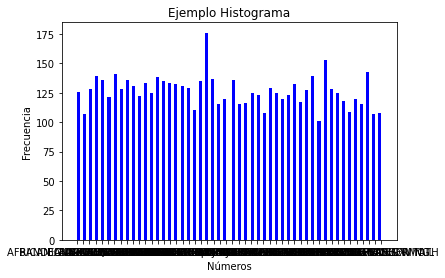

In [ ]:
import matplotlib.pyplot as plt
plt.hist(labels_train, bins = 100, color = "blue", rwidth=1,)
plt.title("Ejemplo Histograma")
plt.xlabel("Números")
plt.ylabel("Frecuencia")
plt.show()

## Vista previa de las imágenes

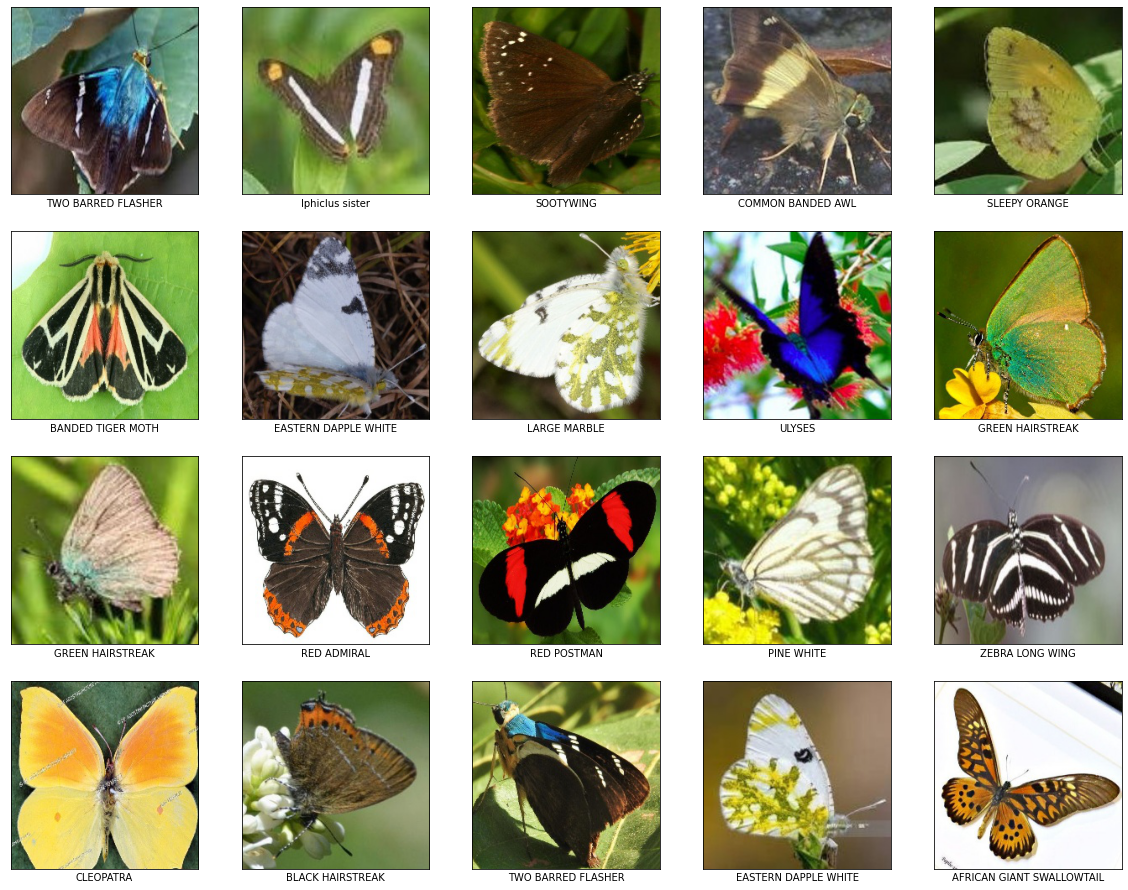

In [ ]:
plt.figure(figsize=(20,20))
ramlist = []
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    ramlist.append(randint(0,len(train)))
    plt.grid(False)
    plt.imshow(train[ramlist[i]])
    plt.xlabel(labels_train[ramlist[i]])
plt.show()

## Redimensionamiento de las imágenes

In [ ]:
# Rezise de las imágenes

# P: Nuevo número de pixeles al cuadrado (P^2 = PXP) de las imagenes (1-224)
P = 112

# R: Reescalado de las imagenes en porcentaje (0-1)
# R = 0.125

auxtrain = []
for img in train:
  #auxtrain.append(rescale(img, (R, R, 1), anti_aliasing=False))
  auxtrain.append(resize(img, (P, P), anti_aliasing=True))
train.clear()
train = auxtrain.copy()

auxtest = []
for img in test:
  #auxtest.append(rescale(img, (R, R, 1), anti_aliasing=False))
  auxtest.append(resize(img, (P, P), anti_aliasing=True))
test.clear()
test = auxtest.copy()

auxvalid = []
for img in valid:
  #auxvalid.append(rescale(img, (R, R, 1), anti_aliasing=False))
  auxvalid.append(resize(img, (P, P), anti_aliasing=True))
valid.clear()
valid = auxvalid.copy()

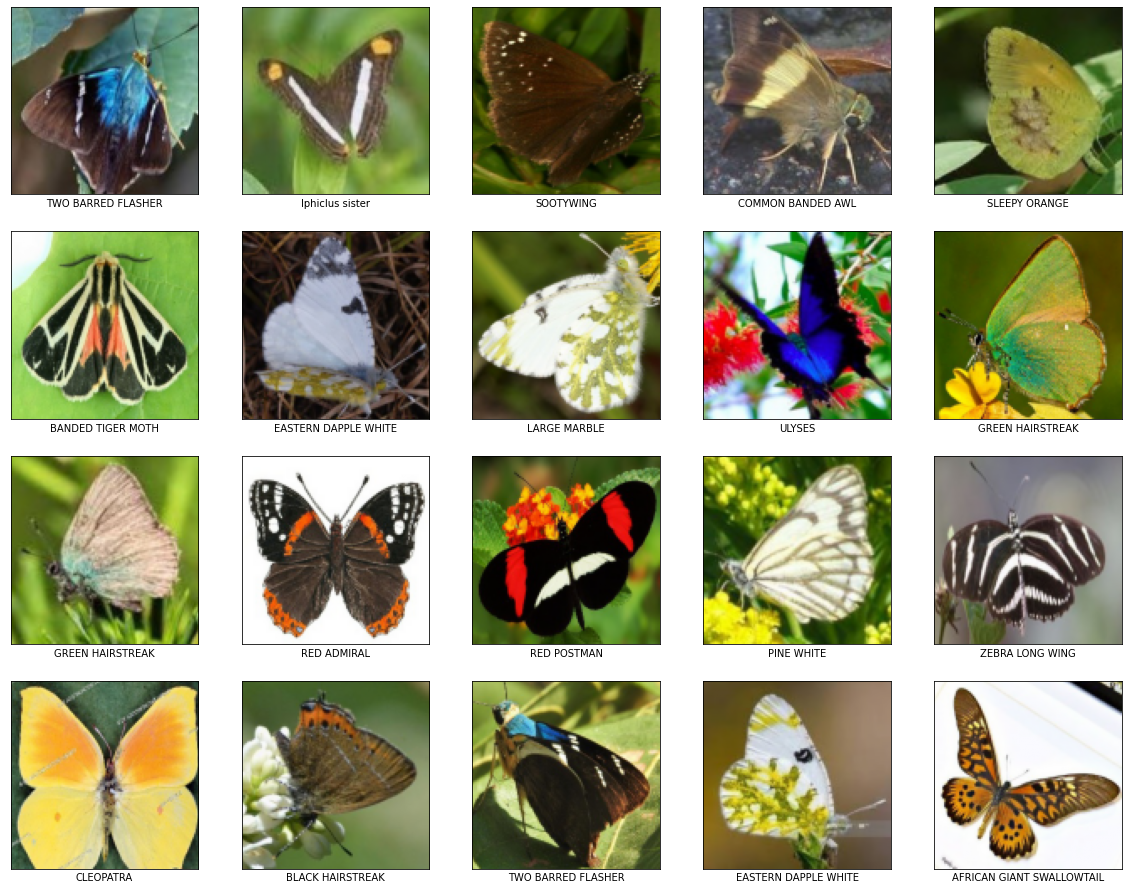

In [ ]:
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[ramlist[i]])
    plt.xlabel(labels_train[ramlist[i]])
plt.show()

## Categorización de las clases

In [ ]:
# Vuelve las clases categóricas

label_train_cat=[]
for i in labels_train:
  label_train_cat.append(claseslist.index(i))
label_train_cat=np.array(label_train_cat)

label_test_cat=[]
for i in labels_test:
  label_test_cat.append(claseslist.index(i))
label_test_cat=np.array(label_test_cat)

label_valid_cat=[]
for i in labels_valid:
  label_valid_cat.append(claseslist.index(i))
label_valid_cat=np.array(label_valid_cat)


In [ ]:
# Pasa de list a np.array

train=np.array(train)
test=np.array(test)
valid=np.array(valid)

#Convertir a flotante y normalizar para que aprenda mejor la red
# train = train.astype('float32') / 255
# test = test.astype('float32') / 255
# valid = valid.astype('float32') / 255

# 'Concatena' los datasets test y valid en test
test = np.append(test, valid,axis=0)
label_test_cat = np.append(label_test_cat,label_valid_cat, axis=0)

print(len(test))
print(len(label_test_cat))

500
500


## Definición del módelo,optimizador y callback


Se define un modelo con 4 capas convoluciones con función de activación relu, y se definen los Kernels como una potencia a la 2 a partir de 2^5 (siempre creciente)
luego se define una capa de dropout al 0.5, y una capa de vuelve la imagen de una sola dimensión, para finalizar con dos capas densas, una Relu nuevamente y una softmax que nos dará el porcentaje de pertenencia de una imagen a las 50 clases.

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), input_shape=(P, P, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(N, activation="softmax")

])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
def create_callbacks(output_folder_path, model_name, stopping_patience, lr_patience):

  csv_logger = CSVLogger(os.path.join(output_folder_path, f"training_metrics_{model_name}.csv"))
  early_stopping = EarlyStopping(patience=stopping_patience, verbose=1, restore_best_weights=True)
  model_checkpoint = ModelCheckpoint(os.path.join(output_folder_path, f"best_{model_name}.hdf5"),
    verbose=1,
    save_best_only=True
  )
  reduce_lr = ReduceLROnPlateau(factor=0.5, patience=lr_patience, min_lr=0.000003125)

  return [csv_logger, early_stopping, model_checkpoint, reduce_lr]


callbacks = create_callbacks(
  os.path.join(WORKSPACE_FOLDER_PATH, OUTPUT_FOLDER_NAME),
  model.name,
  STOPPING_PATIENCE,
  LR_PATIENCE
)

## Entrenamiento del módelo

In [ ]:
history=model.fit(train, label_train_cat, validation_data=(valid, label_valid_cat), epochs=20, callbacks=callbacks)

Epoch 1/20
198/198 [==============================] - ETA: 0s - loss: 2.8952 - accuracy: 0.2158
Epoch 1: val_loss improved from inf to 2.00057, saving model to /content/drive/MyDrive/IA 2022-2/MP4/Outputs/best_sequential_1.hdf5
198/198 [==============================] - 7s 33ms/step - loss: 2.8952 - accuracy: 0.2158 - val_loss: 2.0006 - val_accuracy: 0.4040 - lr: 0.0010
Epoch 2/20
197/198 [============================>.] - ETA: 0s - loss: 1.5570 - accuracy: 0.5405
Epoch 2: val_loss improved from 2.00057 to 1.10448, saving model to /content/drive/MyDrive/IA 2022-2/MP4/Outputs/best_sequential_1.hdf5
198/198 [==============================] - 6s 30ms/step - loss: 1.5567 - accuracy: 0.5406 - val_loss: 1.1045 - val_accuracy: 0.6760 - lr: 0.0010
Epoch 3/20
198/198 [==============================] - ETA: 0s - loss: 1.1023 - accuracy: 0.6592
Epoch 3: val_loss improved from 1.10448 to 0.87046, saving model to /content/drive/MyDrive/IA 2022-2/MP4/Outputs/best_sequential_1.hdf5
198/198 [=========

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 110, 110, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 128)     

## Predicciones

In [ ]:
test_loss, test_acc = model.evaluate(test, label_test_cat)

print('Test accuracy:', test_acc)

16/16 [==============================] - 0s 10ms/step - loss: 0.5882 - accuracy: 0.8420
Test accuracy: 0.8420000076293945


In [ ]:
predictions = model.predict(test)
pruebas = [randint(0,len(predictions)-1) for i in range(20)]
a=[]
b=[]
c=[]
for i in pruebas:
  a.append(claseslist[np.argmax(predictions[i])])
  b.append(claseslist[label_test_cat[i]])
  c.append(claseslist[np.argmax(predictions[i])]==claseslist[label_test_cat[i]])

pd.DataFrame(list(zip(a,b,c)), columns=['Predicción','Valor real','Comparación'])

16/16 [==============================] - 0s 8ms/step


,Predicción,Valor real,Comparación
0,JULIA,JULIA,True
1,MESTRA,MESTRA,True
2,TWO BARRED FLASHER,TWO BARRED FLASHER,True
3,ZEBRA LONG WING,ZEBRA LONG WING,True
4,PURPLISH COPPER,PURPLISH COPPER,True
5,BANDED ORANGE HELICONIAN,BANDED ORANGE HELICONIAN,True
6,CLEOPATRA,CLEOPATRA,True
7,MESTRA,MESTRA,True
8,YELLOW SWALLOW TAIL,YELLOW SWALLOW TAIL,True
9,TWO BARRED FLASHER,TWO BARRED FLASHER,True


## Métricas de Desempeño

In [ ]:
decoded_predictions = predictions.argmax(axis=1)

# Cálculo del reporte de clasificación

print(f'Reporte de clasificación:')
print(classification_report(label_test_cat,
                            decoded_predictions))



Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.91      1.00      0.95        10
           2       1.00      0.90      0.95        10
           3       0.83      1.00      0.91        10
           4       1.00      0.70      0.82        10
           5       0.83      1.00      0.91        10
           6       1.00      0.90      0.95        10
           7       1.00      1.00      1.00        10
           8       0.91      1.00      0.95        10
           9       0.91      1.00      0.95        10
          10       1.00      0.80      0.89        10
          11       0.83      0.50      0.62        10
          12       0.58      0.70      0.64        10
          13       0.70      0.70      0.70        10
          14       0.64      0.70      0.67        10
          15       0.70      0.70      0.70        10
          16       0.50      0.70      0.58        10
 

### Calculo de exactitud (Accuracy)

In [ ]:
# Cálculo de accuracy
print(f'Exactitud (accuracy): {accuracy_score(label_test_cat, decoded_predictions)}')

Exactitud (accuracy): 0.842


### Cálculo de precisión

In [ ]:
# Cálculo de precisión
print(f'Precisión (micro): {precision_score(label_test_cat, decoded_predictions, average="micro")}')
print(f'Precisión (macro): {precision_score(label_test_cat, decoded_predictions, average="macro")}')
print(f'Precisión (weighted): {precision_score(label_test_cat, decoded_predictions, average="weighted")}')

print(f'Precisión por clase:')
print('----')
precision_score_per_class = precision_score(label_test_cat, decoded_predictions, average=None)
for label, score in zip(range(N), precision_score_per_class):
    print(f'\t - Precisión para "{claseslist[label]}": {score}')
print('----')

Precisión (micro): 0.842
Precisión (macro): 0.8584860401036871
Precisión (weighted): 0.8584860401036871
Precisión por clase:
----
	 - Precisión para "ADONIS": 0.8333333333333334
	 - Precisión para "AFRICAN GIANT SWALLOWTAIL": 0.9090909090909091
	 - Precisión para "APPOLLO": 1.0
	 - Precisión para "BANDED ORANGE HELICONIAN": 0.8333333333333334
	 - Precisión para "BANDED TIGER MOTH": 1.0
	 - Precisión para "BLACK HAIRSTREAK": 0.8333333333333334
	 - Precisión para "BROWN SIPROETA": 1.0
	 - Precisión para "CABBAGE WHITE": 1.0
	 - Precisión para "CHECQUERED SKIPPER": 0.9090909090909091
	 - Precisión para "CINNABAR MOTH": 0.9090909090909091
	 - Precisión para "CLEARWING MOTH": 1.0
	 - Precisión para "CLEOPATRA": 0.8333333333333334
	 - Precisión para "COMMON BANDED AWL": 0.5833333333333334
	 - Precisión para "CRECENT": 0.7
	 - Precisión para "DANAID EGGFLY": 0.6363636363636364
	 - Precisión para "EASTERN COMA": 0.7
	 - Precisión para "EASTERN DAPPLE WHITE": 0.5
	 - Precisión para "GARDEN TIGE

### Cálculo de sensibilidad (Recall)

In [ ]:
# Cálculo de recall
print(f'Recall (micro): {recall_score(label_test_cat, decoded_predictions, average="micro")}')
print(f'Recall (macro): {recall_score(label_test_cat, decoded_predictions, average="macro")}')
print(f'Recall (weighted): {recall_score(label_test_cat, decoded_predictions, average="weighted")}')

print(f'Recall por clase:')
print('----')
recall_score_per_class = recall_score(label_test_cat, decoded_predictions, average=None)
for label, score in zip(range(N), recall_score_per_class):
    print(f'\t - Recall  para "{claseslist[label]}": {score}')
print('----')


Recall (micro): 0.842
Recall (macro): 0.8420000000000001
Recall (weighted): 0.842
Recall por clase:
----
	 - Recall  para "ADONIS": 1.0
	 - Recall  para "AFRICAN GIANT SWALLOWTAIL": 1.0
	 - Recall  para "APPOLLO": 0.9
	 - Recall  para "BANDED ORANGE HELICONIAN": 1.0
	 - Recall  para "BANDED TIGER MOTH": 0.7
	 - Recall  para "BLACK HAIRSTREAK": 1.0
	 - Recall  para "BROWN SIPROETA": 0.9
	 - Recall  para "CABBAGE WHITE": 1.0
	 - Recall  para "CHECQUERED SKIPPER": 1.0
	 - Recall  para "CINNABAR MOTH": 1.0
	 - Recall  para "CLEARWING MOTH": 0.8
	 - Recall  para "CLEOPATRA": 0.5
	 - Recall  para "COMMON BANDED AWL": 0.7
	 - Recall  para "CRECENT": 0.7
	 - Recall  para "DANAID EGGFLY": 0.7
	 - Recall  para "EASTERN COMA": 0.7
	 - Recall  para "EASTERN DAPPLE WHITE": 0.7
	 - Recall  para "GARDEN TIGER MOTH": 0.8
	 - Recall  para "GIANT LEOPARD MOTH": 1.0
	 - Recall  para "GREAT EGGFLY": 0.7
	 - Recall  para "GREAT JAY": 1.0
	 - Recall  para "GREEN HAIRSTREAK": 0.9
	 - Recall  para "HERCULES M

### Cálculo del f1-score

In [ ]:
# Cálculo de F1
print(f'F1-micro: {f1_score(label_test_cat, decoded_predictions, average="micro")}')
print(f'F1-macro: {f1_score(label_test_cat, decoded_predictions, average="macro")}')
print(f'F1-weighted: {f1_score(label_test_cat, decoded_predictions, average="weighted")}')

print(f'F1 por clase:')
print('----')
f1_score_per_class = f1_score(label_test_cat, decoded_predictions, average=None)
for label, score in zip(range(N), f1_score_per_class):
    print(f'\t - F1 para "{claseslist[label]}": {score}')
print('----')

F1-micro: 0.842
F1-macro: 0.8395148758252812
F1-weighted: 0.839514875825281
F1 por clase:
----
	 - F1 para "ADONIS": 0.9090909090909091
	 - F1 para "AFRICAN GIANT SWALLOWTAIL": 0.9523809523809523
	 - F1 para "APPOLLO": 0.9473684210526316
	 - F1 para "BANDED ORANGE HELICONIAN": 0.9090909090909091
	 - F1 para "BANDED TIGER MOTH": 0.8235294117647058
	 - F1 para "BLACK HAIRSTREAK": 0.9090909090909091
	 - F1 para "BROWN SIPROETA": 0.9473684210526316
	 - F1 para "CABBAGE WHITE": 1.0
	 - F1 para "CHECQUERED SKIPPER": 0.9523809523809523
	 - F1 para "CINNABAR MOTH": 0.9523809523809523
	 - F1 para "CLEARWING MOTH": 0.888888888888889
	 - F1 para "CLEOPATRA": 0.625
	 - F1 para "COMMON BANDED AWL": 0.6363636363636365
	 - F1 para "CRECENT": 0.7
	 - F1 para "DANAID EGGFLY": 0.6666666666666666
	 - F1 para "EASTERN COMA": 0.7
	 - F1 para "EASTERN DAPPLE WHITE": 0.5833333333333334
	 - F1 para "GARDEN TIGER MOTH": 0.8000000000000002
	 - F1 para "GIANT LEOPARD MOTH": 0.9090909090909091
	 - F1 para "GREAT 

## Graficas

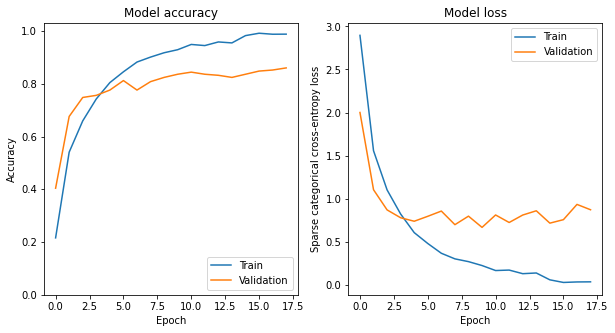

In [ ]:
def plot_learning_curves(training_metrics_csv_path):

  training_metrics = pd.read_csv(training_metrics_csv_path)

  # Se grafican las curvas de aprendizaje para la precisión.
  _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  ax1.plot(training_metrics["accuracy"])
  ax1.plot(training_metrics["val_accuracy"])
  ax1.set(title="Model accuracy", xlabel="Epoch", ylabel="Accuracy")
  ax1.set_ylim(ymin=0)
  ax1.legend(["Train", "Validation"], loc="lower right")

  # Se grafican las curvas de aprendizaje para la pérdida.
  ax2.plot(training_metrics["loss"])
  ax2.plot(training_metrics["val_loss"])
  ax2.set(title="Model loss", xlabel="Epoch", ylabel="Sparse categorical cross-entropy loss")
  ax2.legend(["Train", "Validation"], loc="upper right")


plot_learning_curves(os.path.join(WORKSPACE_FOLDER_PATH, OUTPUT_FOLDER_NAME, f"training_metrics_{model.name}.csv"))

## Matriz de confusión

In [ ]:
#impresion matriz de confusión
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(label=title,fontdict={'fontsize': 30, })
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", size=12,color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Valor verdadero',size=20)
    plt.xlabel('Predicción',size=20)

Confusion matrix, without normalization
[[10  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  7  0  0]
 [ 0  0  0 ...  0  8  0]
 [ 0  0  0 ...  0  0  9]]


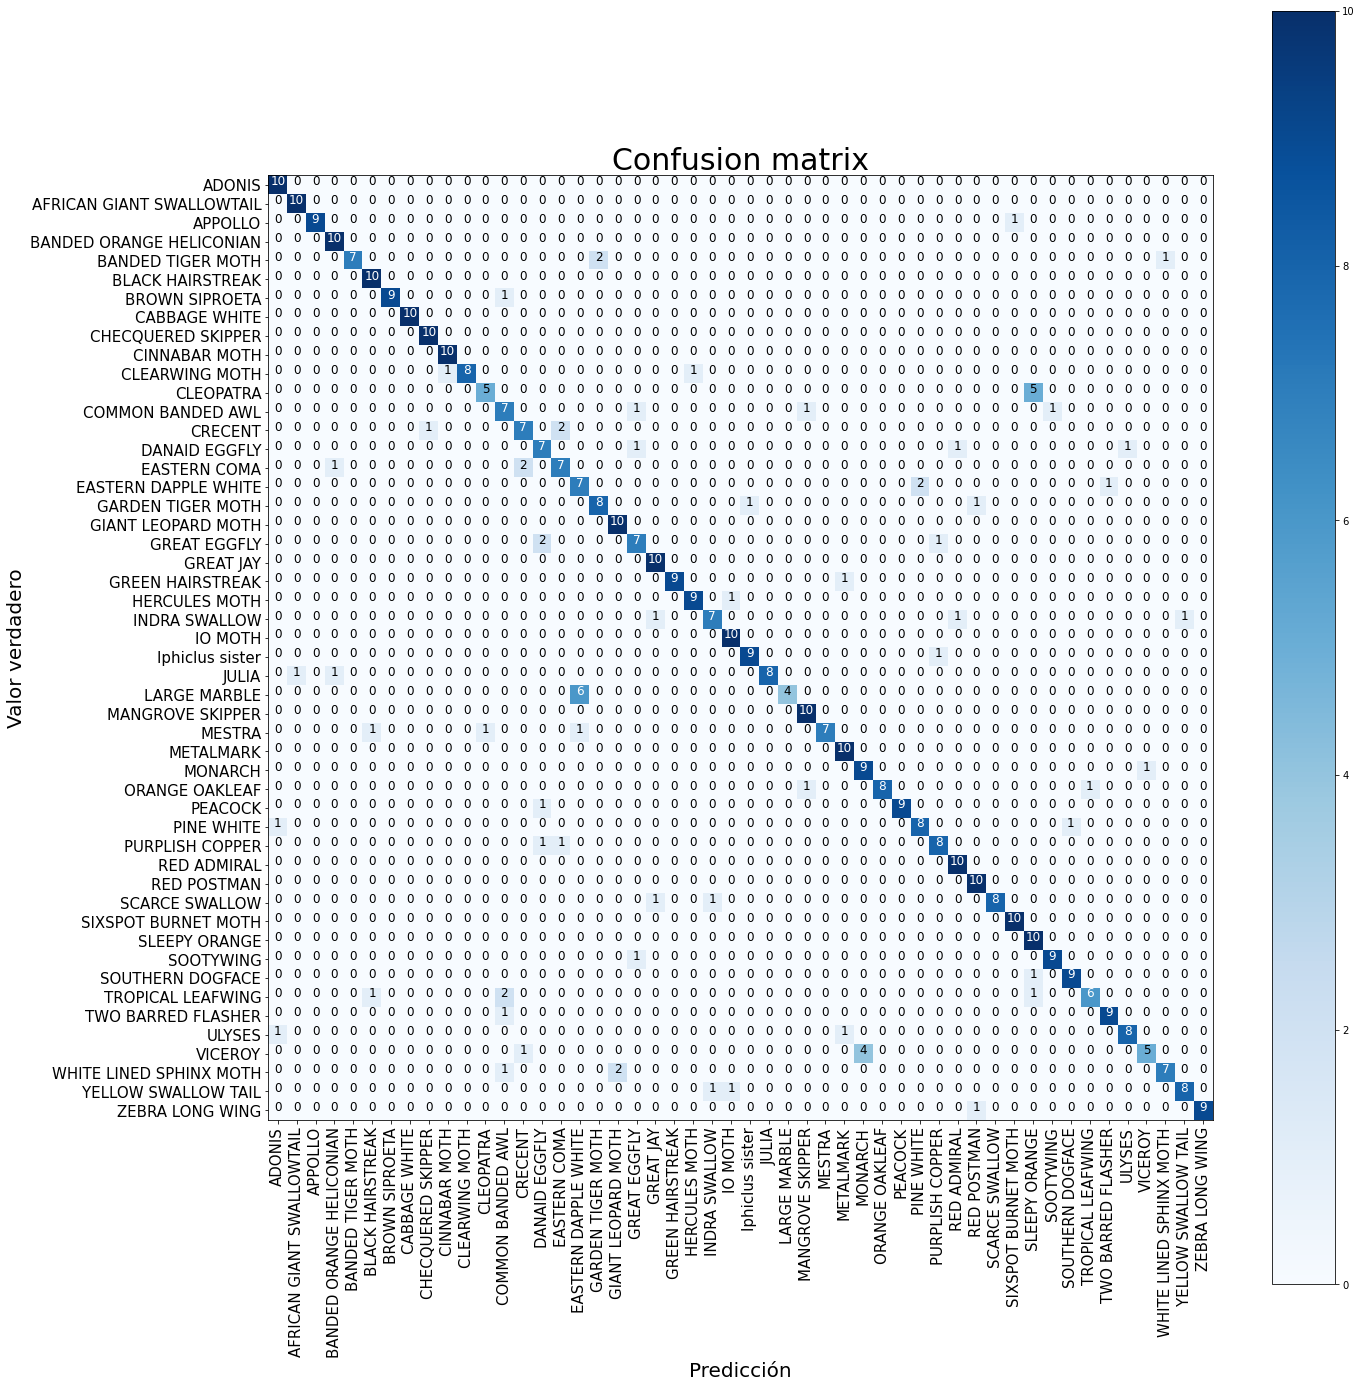

In [ ]:


matrix = confusion_matrix(label_test_cat, decoded_predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(matrix, claseslist)

# Conclusiones.

De la precisión podemos decir que está alrededor de un 80%. Esto significa que aproximadamente el 80% de las mariposas que clasifique el modelo son de la especie que indicó la red neuronal.
Del recall podemos concluir que en la mayoria de ocasiones el modelo predecirá bien 4 de cada 5 especies de mariposas.
Según la exactitud el modelo acierta cerca del 80% de las veces.
Consultando un poco encontramos que la métrica de exactitud no es tan buena, sin embargo podemos ver que la precisión y el recall son muy buenas y son mas precisas, además nuestras clases están bien balanceadas.

Viendo las métricas de exactitud de los algoritmos mostrados en clase y en las prácticas podemos llegar a la conclusión de que nuestra red clasifica de una muy buena manera las mariposas, esto lo explicamos nosotros gracias a el orden tan bueno del dataset, la calidad de las imágenes, además del preprocesamiento de estas y el planteamiento de la red neuronal.

Viendo la matriz de confusión, las especies que mas confunde el modelo son LARGE MARBLE Y EASTERN DAPPLE WHITE


